# Rank customers by predicting their long-term values using BankSim data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import Markdown as md

from functools import partial

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns

from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

from hyperopt import fmin, tpe, hp, anneal, Trials

from sklearn import metrics

# Custom modules

import sys
import os
ROOT_DIR = os.path.abspath('../')
sys.path.insert(0, ROOT_DIR + "/src")

In [2]:
# Constants
RAW_INPUT_PATH = '../data/raw/bs140513_032310.csv'
IGNORE_COLS = ['zipcodeOri', 'zipMerchant']

# Table of contents
1. [Load input](#load-input)
2. [Methodology](#methodology)
3. [Baseline](#baseline)
4. [Probabilistic Approach: BG-NBD](#bg-nbd)
5. [Analyze Frequency/Recency](#analyze-fr)
6. [Ranking customers by their values](#rank)
7. [Calibrate and hold out data](#holdout)
8. [Tune `penalizer_coef` hyper-parameter when fitting BG/NBD](#tune)
9. [Try Gamma-Gamma approach](#gamma-gamma)

# Load input <a class="anchor" id="load-input"></a>

In [3]:
raw_df = pd.read_csv(RAW_INPUT_PATH,
                     quotechar="'",
                     usecols=lambda c: c not in IGNORE_COLS)

In [4]:
cnt_customers = raw_df['customer'].nunique()

In [7]:
md(f"The input value are transaction records of about {cnt_customers:,.0f}"
   " with each `step` corresponding to a date.")

The input value are transaction records of about 4,112 with each `step` corresponding to a date.

In [6]:
raw_df

,step,customer,age,gender,merchant,category,amount,fraud
0,0,C1093826151,4,M,M348934600,es_transportation,4.55,0
1,0,C352968107,2,M,M348934600,es_transportation,39.68,0
2,0,C2054744914,4,F,M1823072687,es_transportation,26.89,0
3,0,C1760612790,3,M,M348934600,es_transportation,17.25,0
4,0,C757503768,5,M,M348934600,es_transportation,35.72,0
...,...,...,...,...,...,...,...,...
594638,179,C1753498738,3,F,M1823072687,es_transportation,20.53,0
594639,179,C650108285,4,F,M1823072687,es_transportation,50.73,0
594640,179,C123623130,2,F,M349281107,es_fashion,22.44,0
594641,179,C1499363341,5,M,M1823072687,es_transportation,14.46,0


# Methodology

First, we need a simple baseline predictions. Then, by comparing results of new sophisticated approaches with this baseline, we will be able to evaluate the gains versus cost of deploying them.

On the other hand, [there are two modeling methods for CLV](https://cloud.google.com/solutions/machine-learning/clv-prediction-with-offline-training-intro):
>- Probabilistic models. These models work by fitting a probability distribution to the observed RFM values for customers. These models are based on buying behavior that's defined by the transaction history for each customer. That data is enough to extract RFM values.
>- ML models. These models are an extensive, widely used class of statistical models in which the parameters are fitted to the data by training with stochastic gradient descent. ML models can make use of more features than the probabilistic models. In this series, we use deep neural network (DNN) models, a popular class of ML models. We also show how to use AutoML Tables to automatically create an ML model.

I approach this problem using Probabilistic methods namely BG/NBD model and Gamma-Gamma, with implementation based on [Python lifetimes package](https://lifetimes.readthedocs.io/en/latest/Quickstart.html#estimating-customer-lifetime-value-using-the-gamma-gamma-model).

The paper for BG/NBD can be found [here](http://www.brucehardie.com/papers/bgnbd_2004-04-20.pdf).

# Baseline <a class="anchor" id="baseline"></a>

Assumption: a user will behave exactly the same in the next `n` days compared to recent `n` days, i.e.:
> Value of a user in the next 30 days = Value of that user in recent 30 days

In [8]:
n = 30
max_step = raw_df['step'].max()
cutoff_step = max_step - n
start_step = cutoff_step - n

In [9]:
y_pred_base = (raw_df.query(f"step > {start_step} and step <= {cutoff_step}")
                     .groupby('customer')['amount'].sum())

In [10]:
y_true = (raw_df.query(f"step > {cutoff_step}")
                .groupby('customer')['amount'].sum())

In [12]:
md(f"Choosing a window of {n} days as holdout validation, below are the predictions of future values of the customer:")

Choosing a window of 30 days as holdout validation, below are the predictions of future values of the customer:

In [11]:
y_df = pd.merge(y_true.to_frame('y_holdout'),
                y_pred_base.to_frame('y_pred_base'),
                how='outer',
                left_index=True,
                right_index=True) \
         .fillna(0)
y_df

,y_holdout,y_pred_base
customer,,
C1000148617,1211.77,683.21
C100045114,1042.75,2565.20
C1000699316,349.98,43.54
C1001065306,501.13,2284.37
C1002658784,993.67,1042.45
...,...,...
C99729647,1520.57,932.45
C998690782,802.33,763.34
C998987490,1691.79,660.19


In [17]:
mae_base = metrics.mean_absolute_error(y_df['y_holdout'],
                                       y_df['y_pred_base'])

In [98]:
md(f"\>> Mean absolute error of Baseline: {mae_base:,.2f}")

\>> Mean absolute error of Baseline: 381.72

# Probabilistic approach: BG/NBD <a class="anchor" id="bg-nbd"></a>

## Calculate features <a class="anchor" id="calc-features"></a>

To be able to use utils function from `lifetimes`, I need to convert each `step` to a pseudo date.
The series below lists `step` in its index and a corresponding date in the value column.

In [24]:
cnt_steps = raw_df['step'].nunique()
pseudo_date_mapper = pd.Series(index=list(range(cnt_steps)),
                               data=pd.date_range("2020-01-01",
                                                  periods=cnt_steps))
raw_df['pseudo_date'] = raw_df['step'].map(pseudo_date_mapper)

In [25]:
pseudo_date_mapper

0     2020-01-01
1     2020-01-02
2     2020-01-03
3     2020-01-04
4     2020-01-05
         ...    
175   2020-06-24
176   2020-06-25
177   2020-06-26
178   2020-06-27
179   2020-06-28
Length: 180, dtype: datetime64[ns]

With the help of util funtion `lifetimes.utils.summary_data_from_transaction_data`, we have the following aggregated DataFrame that summarizes the historical activity levels of all customers.

Note that these features are calculated from all the transaction logs, including holdout data. We use this information to visualize and explore our BG/NBD approach.

In [139]:
%%time
summary_df = summary_data_from_transaction_data(raw_df,
                                                customer_id_col='customer',
                                                datetime_col='pseudo_date',
                                                monetary_value_col='amount')

CPU times: user 969 ms, sys: 109 ms, total: 1.08 s
Wall time: 1.06 s


In [140]:
summary_df

,frequency,recency,T,monetary_value
customer,,,,
C1000148617,127.0,149.0,149.0,35.064331
C100045114,90.0,179.0,179.0,109.016889
C1000699316,92.0,173.0,179.0,38.677174
C1001065306,20.0,134.0,158.0,305.277000
C1002658784,127.0,157.0,157.0,33.778583
...,...,...,...,...
C99729647,168.0,178.0,179.0,33.738452
C998690782,167.0,179.0,179.0,62.397066
C998987490,169.0,179.0,179.0,33.607337


[Definition of our features](https://lifetimes.readthedocs.io/en/latest/Quickstart.html#visualizing-our-frequency-recency-matrix):
> - `frequency` represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.
> - `T` represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
> - `recency` represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.).the
> - `monetary_value` represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.

Note that the above `recency` is not the same as `R` (which is also named recency) from [RFM model in the market research context](https://en.wikipedia.org/wiki/RFM_(market_research)).

## Analyze Frequency/Recency <a class="anchor" id="analyze-fr"></a>

Fitting the features data with BG/NBD implementation `lifetimes.BetaGeoFitter`:

In [72]:
data = summary_df.copy()

In [136]:
%%time
# penalizer_coef=0 yields convergence error
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(data['frequency'], data['recency'], data['T'])

CPU times: user 250 ms, sys: 0 ns, total: 250 ms
Wall time: 240 ms


<lifetimes.BetaGeoFitter: fitted with 4112 subjects, a: 0.00, alpha: 4.24, b: 0.40, r: 3.34>

In [34]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,3.343352,0.060667,3.224444,3.462260
alpha,4.236400,0.085112,4.069581,4.403219
a,0.001129,0.000222,0.000693,0.001564
b,0.401115,0.071826,0.260336,0.541893


Visualize F/R Matrix:

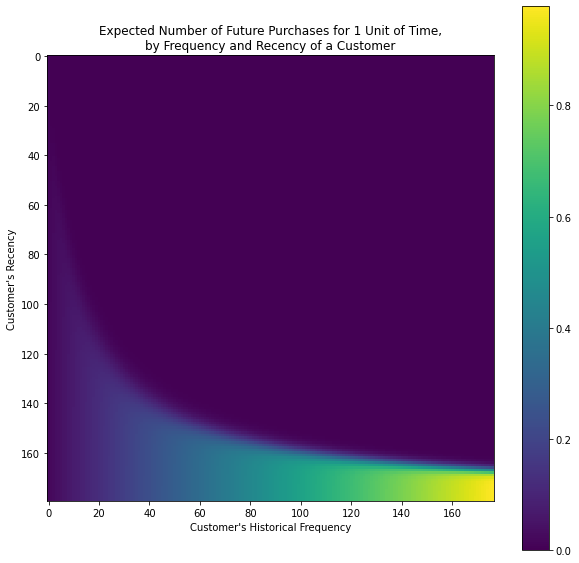

In [35]:
plt.figure(figsize=(10,10))
plot_frequency_recency_matrix(bgf)

The lighter is the more valuable customers with a high chance of repeated transactions. The visualization shows that our best customers are those that have made more than ~130 transactions out of 180 days, with their tenure ranging from 160 to 180 days. Intuitively, these customers on average purchase 4 times every 5 days in the last six months!

Visualize Probability of Alive:

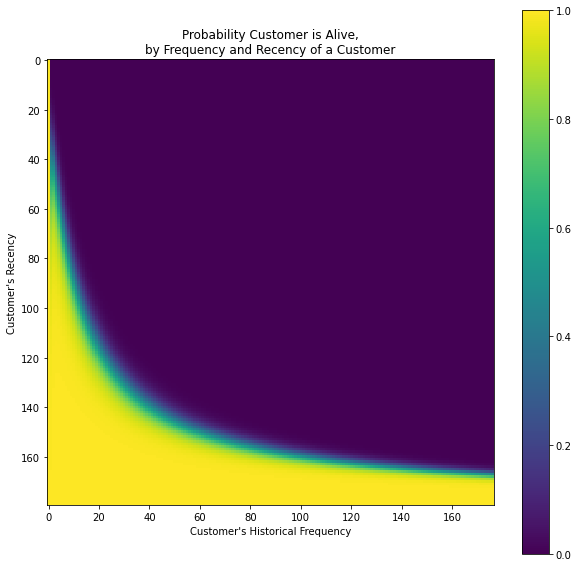

In [36]:
plt.figure(figsize=(10,10))
plot_probability_alive_matrix(bgf)

The above plot suggests that if we care about probability of alive, we should focus encouraging long tenure relationship with users instead of encouraging them to over-spend from the beginning. It also says that of all the customers that have been with us for 3 months, the ones making less than 10 purchases indicates sustainability.

In [73]:
t = 1
fn_pred_expected_purchases = bgf.conditional_expected_number_of_purchases_up_to_time
ppt_name = f'predicted_purchases_{t}'
data[ppt_name] = fn_pred_expected_purchases(t,
                                            data['frequency'],
                                            data['recency'],
                                            data['T'])

# Ranking customers by their values <a class='anchor' id='rank'>

In [84]:
md(f"#### Ranking customers from best to worst by probability of purchasing in the next {t} day")

#### Ranking customers from best to worst by probability of purchasing in the next 30 day

In [75]:
data.sort_values(by=ppt_name).tail(5)

,frequency,recency,T,monetary_value,predicted_purchases_1
customer,,,,,
C1882101149,176.0,179.0,179.0,33.980057,0.978745
C1999699557,176.0,179.0,179.0,34.455170,0.978745
C1155962240,176.0,179.0,179.0,34.845852,0.978745
C333484923,176.0,179.0,179.0,32.946818,0.978745
C222098023,176.0,179.0,179.0,31.382443,0.978745


To estimate the expected value in $, we can use multiply the `monetary_value` with `predicted_purchases` as monetary_value is [equal to the sum of all a customer’s purchases divided by the total number of purchases](https://lifetimes.readthedocs.io/en/latest/Quickstart.html#example-using-transactional-datasets).

In [76]:
pvt_name = f'predicted_value_{t}'
data[pvt_name] = (data[ppt_name]
                  * data['monetary_value'])

In [77]:
data.sort_values([pvt_name], ascending=False) \
    .head() \
    .style.format("{:,.0f}", subset=[pvt_name, 'frequency',
                                     'recency', 'T',
                                     'monetary_value']) \
          .format("{:,.2f}", subset=[ppt_name]) \
          .bar(vmin=0, subset=[pvt_name])

,frequency,recency,T,monetary_value,predicted_purchases_1,predicted_value_1
customer,,,,,,
C806399525,134,148,148,625,0.90,563
C2004941826,89,165,168,725,0.54,389
C1849046345,107,167,167,563,0.64,363
C1350963410,118,167,167,474,0.71,336
C1572610482,70,171,177,829,0.40,335


Distribution of `predicted_value_1`

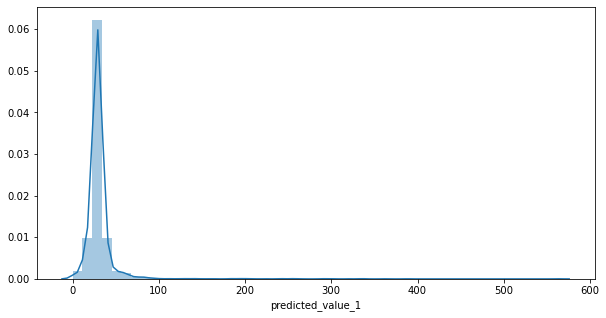

In [53]:
plt.figure(figsize=(10,5))
sns.distplot(data[pvt_name])

The distribution is right-skewed, with expected values lie in range (20, 30).

#### As the problem requires calculating users' long term values, I proceed by making the following assumptions:

1. \# of purchases in K days = P(purchase|1 day) * \# days
2. Average spending of customer does not change in the next K days period

In [78]:
long_term_periods = 30

In [79]:
t = long_term_periods
fn_pred_expected_purchases = bgf.conditional_expected_number_of_purchases_up_to_time
ppt_name = f'predicted_purchases_{t}'
data[ppt_name] = fn_pred_expected_purchases(t,
                                            data['frequency'],
                                            data['recency'],
                                            data['T'])
data.sort_values(by=ppt_name).tail(5)

,frequency,recency,T,monetary_value,predicted_purchases_1,predicted_value_1,predicted_purchases_30
customer,,,,,,,
C1882101149,176.0,179.0,179.0,33.980057,0.978745,33.257797,29.3598
C1999699557,176.0,179.0,179.0,34.455170,0.978745,33.722811,29.3598
C1155962240,176.0,179.0,179.0,34.845852,0.978745,34.105189,29.3598
C333484923,176.0,179.0,179.0,32.946818,0.978745,32.246520,29.3598
C222098023,176.0,179.0,179.0,31.382443,0.978745,30.715396,29.3598


In [80]:
pvt_name = f'predicted_value_{t}'
data[pvt_name] = (data[ppt_name]
                  * data['monetary_value'])

In [81]:
data.sort_values([pvt_name], ascending=False) \
    .head(10) \
    .style.format("{:,.0f}", subset=[pvt_name, 'frequency',
                                     'recency', 'T',
                                     'monetary_value']) \
          .format("{:,.2f}", subset=[ppt_name]) \
          .bar(vmin=0, subset=[pvt_name])

,frequency,recency,T,monetary_value,predicted_purchases_1,predicted_value_1,predicted_purchases_30,predicted_value_30
customer,,,,,,,,
C806399525,134,148,148,625,0.902161,563.463664,27.06,"16,902"
C2004941826,89,165,168,725,0.536107,388.581783,16.08,"11,656"
C1849046345,107,167,167,563,0.644383,362.936675,19.33,"10,887"
C1350963410,118,167,167,474,0.708621,336.065068,21.26,"10,081"
C1572610482,70,171,177,829,0.404604,335.489438,12.14,"10,064"
C1978250683,163,170,170,336,0.954689,321.096896,28.64,"9,632"
C381007057,67,174,174,765,0.394655,301.762138,11.84,"9,052"
C483912131,67,176,176,753,0.390276,293.934898,11.71,"8,817"
C1275518867,166,179,179,313,0.924170,289.659677,27.72,"8,689"


# Assessing model fit <a class="anchor" id="eval"></a>

We can use the our fitted BG/NBD model to generate data points and compared them to the historical actual values. A best fitted model will have identical height bars at each of the calibration period.

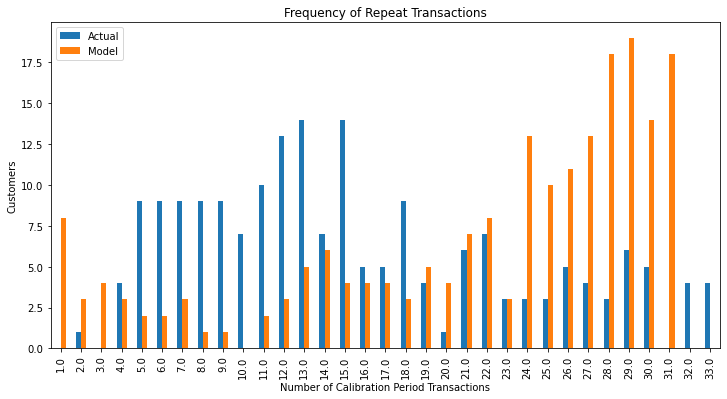

In [83]:
plot_period_transactions(bgf, max_frequency=30, figsize=(12,6))

The above plot implies that model works well with predictions ranging from 14 to 23 transactions. It tends to under-estimate for the lower end while being over-confident at the higher end.

## Calibrate and hold out data <a class="anchor" id="holdout"></a>

To estimate the fitness of our model compared with baseline, I set the last 30 days as the holdout period. We re-calculate the model with the first 150 days of data.

Below is the summary of re-calculated features.

In [85]:
summary_cal_holdout = calibration_and_holdout_data(
    raw_df, 'customer', 'pseudo_date',
    monetary_value_col='amount',
    calibration_period_end='2020-05-29',
    observation_period_end='2020-06-28' )

In [86]:
summary_cal_holdout

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer,,,,,,,
C1000148617,101.0,117.0,119.0,32.093069,26.0,43.277500,30.0
C100045114,61.0,149.0,149.0,143.750328,29.0,31.598485,30.0
C1000699316,90.0,141.0,149.0,35.648000,2.0,116.660000,30.0
C1001065306,18.0,123.0,128.0,311.356111,2.0,250.565000,30.0
C1002658784,100.0,127.0,127.0,32.962100,27.0,36.802593,30.0
...,...,...,...,...,...,...,...
C99729647,140.0,149.0,149.0,29.624929,28.0,50.685667,30.0
C998690782,139.0,149.0,149.0,69.194101,28.0,26.744333,30.0
C998987490,142.0,149.0,149.0,28.083451,27.0,54.573871,30.0


Visualize the actual frequency versus model predictions

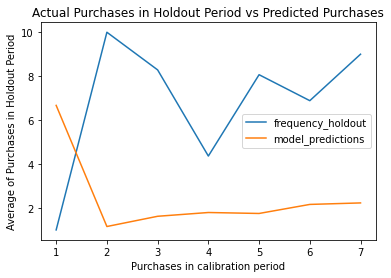

In [87]:
bgf.fit(summary_cal_holdout['frequency_cal'],
        summary_cal_holdout['recency_cal'],
        summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf,
                                                summary_cal_holdout)

They are not the best fitted couples in the world with low calibration purchases, but somehow align their movements with higher purchases.

# Compare to baseline

In [88]:
long_term_periods = 30

Estimate the predicted number of purchases:

In [89]:
t = long_term_periods
fn_pred_expected_purchases = bgf.conditional_expected_number_of_purchases_up_to_time
ppt_name = f'predicted_purchases_{t}'
summary_cal_holdout[ppt_name] = fn_pred_expected_purchases(
    t,
    summary_cal_holdout['frequency_cal'],
    summary_cal_holdout['recency_cal'],
    summary_cal_holdout['T_cal'])
summary_cal_holdout.sort_values(by=ppt_name).tail(5)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,predicted_purchases_30
customer,,,,,,,,
C369046885,146.0,149.0,149.0,32.659452,29.0,31.046364,30.0,29.235200
C1155962240,147.0,149.0,149.0,32.920136,29.0,43.120333,30.0,29.431421
C1698085181,147.0,149.0,149.0,31.735918,27.0,31.842857,30.0,29.431421
C220904895,147.0,149.0,149.0,32.800544,26.0,22.560385,30.0,29.431421
C333484923,148.0,149.0,149.0,31.455676,28.0,39.420690,30.0,29.627642


Muliply with average monetary value:

In [90]:
pvt_name = f'predicted_value_{t}'
summary_cal_holdout[pvt_name] = (summary_cal_holdout[ppt_name]
                                 * summary_cal_holdout['monetary_value_cal'])

In [91]:
summary_cal_holdout.sort_values([pvt_name], ascending=False)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,predicted_purchases_30,predicted_value_30
customer,,,,,,,,,
C806399525,106.0,118.0,118.0,746.732358,28.0,108.070000,30.0,2.682559e+01,2.003154e+04
C1849046345,81.0,137.0,137.0,710.681852,26.0,84.391563,30.0,1.788457e+01,1.271024e+04
C1572610482,66.0,147.0,147.0,872.977879,4.0,106.500000,30.0,1.371696e+01,1.197460e+04
C2004941826,74.0,138.0,138.0,728.775270,15.0,480.899091,30.0,1.627850e+01,1.186336e+04
C1350963410,90.0,137.0,137.0,563.016222,28.0,110.213958,30.0,1.980098e+01,1.114827e+04
...,...,...,...,...,...,...,...,...,...
C1607207670,86.0,106.0,149.0,36.902907,13.0,41.823571,30.0,1.832931e-07,6.764049e-06
C1683902488,56.0,88.0,149.0,38.226071,5.0,142.190000,30.0,4.129732e-08,1.578634e-06
C1058785965,50.0,82.0,149.0,46.876400,3.0,115.852500,30.0,1.959130e-08,9.183695e-07


In [92]:
y_pred_bgf = summary_cal_holdout[pvt_name]

In [93]:
y_df = y_df.join(y_pred_bgf).rename(columns={'predicted_value_30': 'y_pred_bgf'})

Predictions of total monetary value in the holdout period:

In [109]:
y_df

,y_holdout,y_pred_base,y_pred_bgf
customer,,,
C1000148617,1211.77,683.21,814.685454
C100045114,1042.75,2565.20,1804.989216
C1000699316,349.98,43.54,648.971354
C1001065306,501.13,2284.37,1486.480857
C1002658784,993.67,1042.45,778.097429
...,...,...,...
C99729647,1520.57,932.45,831.212542
C998690782,802.33,763.34,1927.862099
C998987490,1691.79,660.19,798.983068


In [94]:
mae_bgf = metrics.mean_absolute_error(y_df['y_holdout'],
                                      y_df['y_pred_bgf'])

In [100]:
md(f"\\>> Mean absolute error of BG/NBD: {mae_bgf:,.2f}")

\>> Mean absolute error of BG/NBD: 352.04

In [103]:
delta = 1 - mae_bgf / mae_base

In [108]:
md(f"\>> Compared to Baseline MAE of {mae_base:,.2f}, BG/NBD model decreases error by {delta:,.0%}.")

\>> Compared to Baseline MAE of 381.72, BG/NBD model decreases error by 8%.

# Tune `penalizer_coef` hyper-parameter when fitting BG/NBD <a class='anchor' id='tune'>

Given a mechanism to quantify the fitness of BG/NBD model, we can fine-tune the configuration through searching. Below I set up a loss function which is the discrepancy between model predictions and actual holdout data. Then, I begin looking for a better `penalizer_coef` params for constructing BG/NBD model with the help of The Tree-structured Parzen Estimator (TPE) (a sequential model-based optimization) implemented in the `hyperopt` package.

```
def get_results(summary, model, kind, n):
    duration_holdout = summary.iloc[0]["duration_holdout"]

    summary["model_predictions"] = model.conditional_expected_number_of_purchases_up_to_time(
            duration_holdout, summary["frequency_cal"], summary["recency_cal"], summary["T_cal"])

    results = (summary.groupby(kind)
                      [["frequency_holdout", "model_predictions"]]
                      .mean().iloc[:n])
    return results

def tune(params, summary, n, random_state):
    params = {'penalizer_coef': float(params['penalizer_coef'])}
    kind = 'frequency_cal'
    
    model = BetaGeoFitter(**params)
    model.fit(summary['frequency_cal'],
              summary['recency_cal'],
              summary['T_cal'])
    
    results = get_results(summary, model, kind, n)
    y_true = results['model_predictions']
    y_pred = results['frequency_holdout']
    
    score = np.sqrt(metrics.mean_squared_error(y_true, y_pred))

    return score
```

In [113]:
def get_results(summary, model, kind, n):
    duration_holdout = summary.iloc[0]["duration_holdout"]

    summary["model_predictions"] = model.conditional_expected_number_of_purchases_up_to_time(
            duration_holdout, summary["frequency_cal"], summary["recency_cal"], summary["T_cal"])

    results = (summary.groupby(kind)
                      [["frequency_holdout", "model_predictions"]]
                      .mean().iloc[:n])
    return results

def tune(params, summary, n, random_state):
    params = {'penalizer_coef': float(params['penalizer_coef'])}
    kind = 'frequency_cal'
    
    model = BetaGeoFitter(**params)
    model.fit(summary['frequency_cal'],
              summary['recency_cal'],
              summary['T_cal'])
    
    results = get_results(summary, model, kind, n)
    y_true = results['model_predictions']
    y_pred = results['frequency_holdout']
    
    score = np.sqrt(metrics.mean_squared_error(y_true, y_pred))

    return score

The search range of (0.001, 0.1) is suggested by `lifetimes` [here](https://lifetimes.readthedocs.io/en/latest/Quickstart.html#visualizing-our-frequency-recency-matrix).
>For small samples sizes, the parameters can get implausibly large, so by adding an l2 penalty the likelihood, we can control how large these parameters can be. This is implemented as setting as positive penalizer_coef in the initialization of the model. In typical applications, penalizers on the order of 0.001 to 0.1 are effective.

After running for about 400 iterations, here is the best result:

In [ ]:
params = {'penalizer_coef': hp.uniform("penalizer_coef",
                                       0.001, 0.1)}
n = 30
# n_iter = 10
timeout = 120
random_state = 42

fn_tune = partial(tune, summary=summary_cal_holdout.copy(), n=30,
                  random_state=random_state)

trials = Trials()

best=fmin(fn=fn_tune, # function to optimize
          space=params,
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
#           max_evals=n_iter, # maximum number of iterations
          timeout=timeout,
          verbose=0,
          trials=trials, # logging
          rstate=np.random.RandomState(random_state), # fixing random state for the reproducibility
          catch_eval_exceptions=True
         )

In [128]:
best

{'penalizer_coef': 0.0010005407823014728}

Note that above, for the sake of displaying, I truncated the errors happening at some iterations.

Visualize the finding process:

In [129]:
tpe_results = np.array([[x['result']['loss'],
                         x['misc']['vals']['penalizer_coef'][0]] for x in trials.trials])

tpe_results_df = pd.DataFrame(tpe_results,
                              columns=['score', 'penalizer_coef'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f797f1a7640>,
      dtype=object)

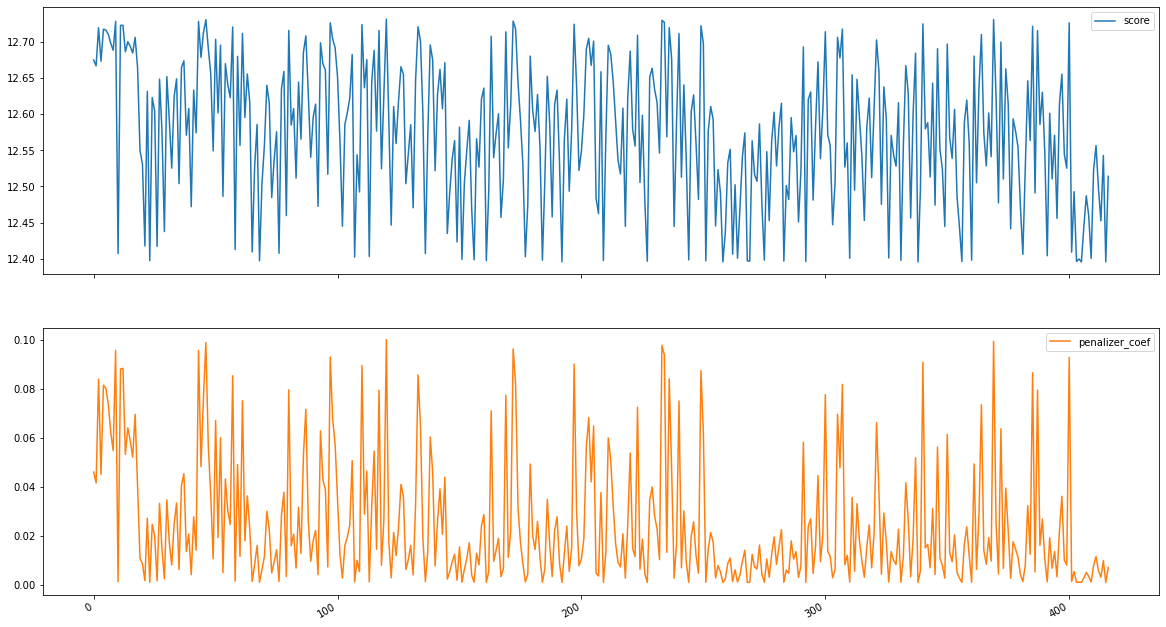

In [131]:
tpe_results_df.plot(subplots=True,figsize=(20, 12))

# Gamma-Gamma <a class='anchor' id='gamma-gamma'>

Inputs are our calculated features:

In [132]:
summary_df

,frequency,recency,T,monetary_value
customer,,,,
C1000148617,127.0,149.0,149.0,35.064331
C100045114,90.0,179.0,179.0,109.016889
C1000699316,92.0,173.0,179.0,38.677174
C1001065306,20.0,134.0,158.0,305.277000
C1002658784,127.0,157.0,157.0,33.778583
...,...,...,...,...
C99729647,168.0,178.0,179.0,33.738452
C998690782,167.0,179.0,179.0,62.397066
C998987490,169.0,179.0,179.0,33.607337


[According to `lifetimes` docs](https://lifetimes.readthedocs.io/en/latest/Quickstart.html#example-using-transactional-datasets):
>The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [133]:
returning_customers_summary = (summary_df[summary_df['frequency']>0])

Checking Pearson correlation in our data:

In [181]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,-0.531216
frequency,-0.531216,1.000000


It can be seen that `monetary_value` and `frequency` are moderately negatively correlated, so we should not use Gamma-Gamma approach.

# Summary

In this notebook, I approach the Customer Long-term Values problem by Probabilistic Model BG/NBD. Compared to a simple baseline of predicting next transaction, it yields an improvement of 8% in Mean Absolute Error. The cost of fitting BG/NBD model is trivial with less than 500ms for 4,000 customers and an additional under 2000ms to calculate 3 features from raw 500,000 transactions.

# Next steps

The probabilistic approaches take advantage of simplicity and backed by academic research. However, they can not utilize holistic data about users, thus being restricted in the ability to improve themselves. Given more data and time, I would like to tackle this problem using Machine Learning approach, constructing the long-term value labels for users.